In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

2024-06-23 11:55:38.715948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Daten einlesen lokal LP
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
kiwo_df = pd.read_csv('kiwo.csv')
wetter_df = pd.read_csv('wetter.csv')
rohertrag_df = pd.read_csv('rohertrag.csv')

# Convert date columns to datetime format
train_df['Datum'] = pd.to_datetime(train_df['Datum'])
test_df['Datum'] = pd.to_datetime(test_df['Datum'])
wetter_df['Datum'] = pd.to_datetime(wetter_df['Datum'])
kiwo_df['Datum'] = pd.to_datetime(kiwo_df['Datum'])
rohertrag_df['Datum'] = pd.to_datetime(rohertrag_df['Datum'])

rohertrag_df
#train_df

,Datum,Rohertrag_daily
0,2013-04-30,27974.243452
1,2013-05-01,27974.243452
2,2013-05-02,27974.243452
3,2013-05-03,27974.243452
4,2013-05-04,27974.243452
...,...,...
2263,2019-07-28,31569.758466
2264,2019-07-29,31569.758466
2265,2019-07-30,31569.758466
2266,2019-07-31,31569.758466


In [6]:
# Merge the datasets
train_df = pd.merge(train_df, wetter_df, on='Datum', how='left')
test_df = pd.merge(test_df, wetter_df, on='Datum', how='left')

train_df = pd.merge(train_df, kiwo_df, on='Datum', how='left')
test_df = pd.merge(test_df, kiwo_df, on='Datum', how='left')

train_df = pd.merge(train_df, rohertrag_df, on='Datum', how='left')
test_df = pd.merge(test_df, rohertrag_df, on='Datum', how='left')

# Fill missing values

train_df['KielerWoche'] = train_df['KielerWoche'].fillna(0)
test_df['KielerWoche'] = test_df['KielerWoche'].fillna(0)



#train_df.to_csv('train_df-Tensorflow_v6.csv', index=False)
print(train_df)


           id      Datum  Warengruppe      Umsatz  Bewoelkung_x  Temperatur_x  \
0     1307011 2013-07-01            1  148.828353           6.0       17.8375   
1     1307021 2013-07-02            1  159.793757           3.0       17.3125   
2     1307031 2013-07-03            1  111.885594           7.0       21.0750   
3     1307041 2013-07-04            1  168.864941           7.0       18.8500   
4     1307051 2013-07-05            1  171.280754           5.0       19.9750   
...       ...        ...          ...         ...           ...           ...   
9329  1712216 2017-12-21            6   87.471228           7.0        6.2375   
9330  1712226 2017-12-22            6   71.911652           7.0        5.7625   
9331  1712236 2017-12-23            6   84.062223           7.0        7.8000   
9332  1712246 2017-12-24            6   60.981969           7.0        8.1125   
9333  1712276 2017-12-27            6   34.972644           7.0        4.6125   

      Windgeschwindigkeit_x

In [9]:
# Handle missing values in weather-related columns
train_df['Bewoelkung'] = train_df['Bewoelkung'].fillna(train_df['Bewoelkung'].mean())
train_df['Temperatur'] = train_df['Temperatur'].fillna(train_df['Temperatur'].mean())
train_df['Windgeschwindigkeit'] = train_df['Windgeschwindigkeit'].fillna(train_df['Windgeschwindigkeit'].mean())
train_df['Wettercode'] = train_df['Wettercode'].fillna(train_df['Wettercode'].mode()[0])

test_df['Bewoelkung'] = test_df['Bewoelkung'].fillna(test_df['Bewoelkung'].mean())
test_df['Temperatur'] = test_df['Temperatur'].fillna(test_df['Temperatur'].mean())
test_df['Windgeschwindigkeit'] = test_df['Windgeschwindigkeit'].fillna(test_df['Windgeschwindigkeit'].mean())
test_df['Wettercode'] = test_df['Wettercode'].fillna(test_df['Wettercode'].mode()[0])

train_df['Rohertrag_daily'] = train_df['Rohertrag_daily'].fillna(train_df['Rohertrag_daily'].mean())
test_df['Rohertrag_daily'] = test_df['Rohertrag_daily'].fillna(test_df['Rohertrag_daily'].mean())

In [10]:
# Feature engineering: Extract additional features from the date column
def extract_date_features(df):
    df['Year'] = df['Datum'].dt.year
    df['Month'] = df['Datum'].dt.month
    df['Day'] = df['Datum'].dt.day
    df['DayOfWeek'] = df['Datum'].dt.dayofweek
    df['WeekOfYear'] = df['Datum'].dt.isocalendar().week
    df['Quarter'] = df['Datum'].dt.quarter

    return df

train_df = extract_date_features(train_df)
test_df = extract_date_features(test_df)

train_df
#test_df


,id,Datum,Warengruppe,Umsatz,Bewoelkung_x,Temperatur_x,Windgeschwindigkeit_x,Wettercode_x,KielerWoche_x,Rohertrag_daily_x,...,Windgeschwindigkeit,Wettercode,KielerWoche,Rohertrag_daily,Year,Month,Day,DayOfWeek,WeekOfYear,Quarter
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0.0,27974.243452,...,15.0,20.0,0.0,27974.243452,2013,7,1,0,27,3
1,1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,NaN,0.0,27974.243452,...,10.0,61.0,0.0,27974.243452,2013,7,2,1,27,3
2,1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,0.0,27974.243452,...,6.0,61.0,0.0,27974.243452,2013,7,3,2,27,3
3,1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,0.0,27974.243452,...,7.0,20.0,0.0,27974.243452,2013,7,4,3,27,3
4,1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,NaN,0.0,27974.243452,...,12.0,61.0,0.0,27974.243452,2013,7,5,4,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1712216,2017-12-21,6,87.471228,7.0,6.2375,10.0,21.0,0.0,30755.094000,...,10.0,21.0,0.0,30755.094000,2017,12,21,3,51,4
9330,1712226,2017-12-22,6,71.911652,7.0,5.7625,9.0,10.0,0.0,30755.094000,...,9.0,10.0,0.0,30755.094000,2017,12,22,4,51,4
9331,1712236,2017-12-23,6,84.062223,7.0,7.8000,19.0,61.0,0.0,30755.094000,...,19.0,61.0,0.0,30755.094000,2017,12,23,5,51,4
9332,1712246,2017-12-24,6,60.981969,7.0,8.1125,16.0,61.0,0.0,30755.094000,...,16.0,61.0,0.0,30755.094000,2017,12,24,6,51,4


In [11]:
# Define features and target variable
features = ['Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 
            'KielerWoche', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'Warengruppe', 'Rohertrag_daily']
target = 'Umsatz'

X = train_df[features]
y = train_df[target]




In [12]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(test_df[features])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Build the neural network model using TensorFlow
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1)
])

model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 12,609 (49.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [14]:


model.compile(loss="mse", optimizer=Adam (learning_rate=0.001))

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=90, batch_size=32)



Epoch 1/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 64993.8359 - val_loss: 55003.4141
Epoch 2/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 62959.6484 - val_loss: 50292.9688
Epoch 3/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55873.6914 - val_loss: 42524.1016
Epoch 4/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 44027.3242 - val_loss: 30378.7305
Epoch 5/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 32441.4277 - val_loss: 18093.6523
Epoch 6/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21547.1855 - val_loss: 12586.1357
Epoch 7/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15447.8184 - val_loss: 6727.0952
Epoch 8/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10291.0967 - val_loss: 4348.2192
Epoch 9/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8454.7041 - val_loss: 3205.5901
Epoch 10/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7378.8618 - val_loss: 2427.3003
Epoch 11/90
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6919

In [15]:
# Evaluate the model
y_pred = model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f'TensorFlow Neural Network MAPE: {mape}')

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
TensorFlow Neural Network MAPE: 0.19479604286198365


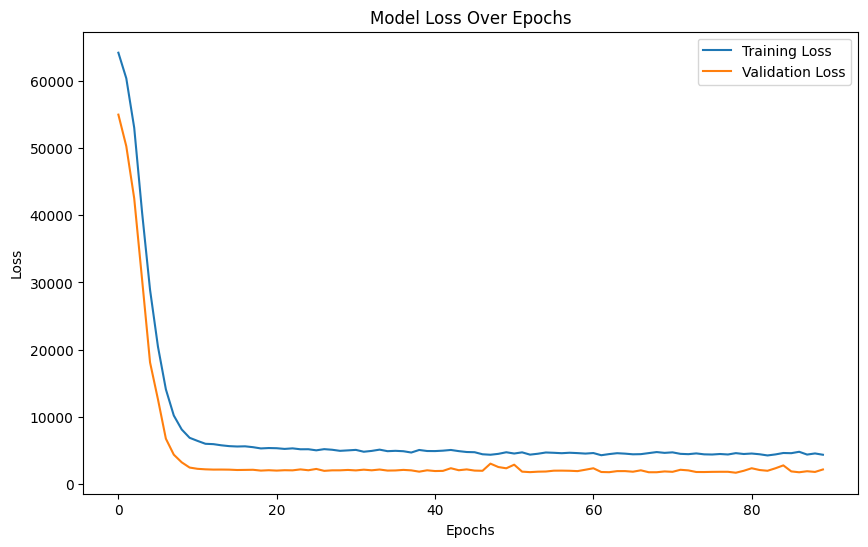

In [16]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
# Make predictions on the test set
test_predictions = model.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


In [18]:
# Prepare the submission file
submission_df = test_df[['id']].copy()
submission_df['umsatz'] = test_predictions
submission_df.to_csv('Tensorflow_v6.csv', index=False)